# In Silico Identification of Novel Compounds  for the treatment of Insomnia
    MSc in Computational Biology
    Computational Structural Biology for Lead Discovery
    January 2024

------

In [1]:
# libraries
import json  # lets us work with the json format
import requests  # allows Python to make web requests
import pandas as pd # analysis of tabular data
import numpy as np # numerical library

In [2]:
import rdkit.Chem.AllChem as AllChem # rdkit. chemoinformatics
import rdkit.Chem as Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import PandasTools
from rdkit import DataStructs
from rdkit.Chem import rdFingerprintGenerator
import math
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import SDWriter
from rdkit.Chem import rdMolAlign
import pandas as pd
import copy
import os # OS: Operating System interface for interacting with the file system
import collections # Collections: High-performance container datatypes
from collections import Counter # Collections: Counter, a dictionary subclass for counting hashable objects
import nglview as nv # NGLview: Molecular visualization in Jupyter notebooks
import time
#!pip install nglview
import py3Dmol #widget to embed an interactive [3Dmol.js]
import math # Math: Mathematical functions
from sklearn import cluster # scikit-learn: Machine learning library for clustering
from sklearn.cluster import KMeans  #KMeans clustering algorithm
import operator

The orexin receptors mediate the actions of the neuropeptides orexin A and orexin B (also called hypocretin 1 and hypocretin 2). These neuropeptides are produced by neurons primarily located in the lateral hypothalamus and are involved in regulating various physiological functions, including sleep-wake cycles, arousal, appetite, and stress responses.

Pharmacological modulation of these receptors has been explored as a potential therapeutic target for sleep disorders, particularly in developing medications for conditions like insomnia. Additionally, OX2R and dual orexin receptor antagonists, but not OX1R antagonists, inhibit wakefulness.


## **Protein First Analysis**
---

I would like to find a drug that can act as an inhibitor of the activity of these OX2R, with the UniProt code O43614.

In [ ]:
BASE_URL = "https://www.ebi.ac.uk/chembl/api/data/{:s}"
#Find protein in the ChEMBL database
target_protein_url = BASE_URL.format("target_component?accession=O43614")
target_components = requests.get(target_protein_url, headers={"Accept":"application/json"}).json()['target_components']
target_components[0]['targets']


In [ ]:
targets_list = ';'.join([i['target_chembl_id'] for i in target_components[0]['targets']])
targets_url = BASE_URL.format("target/set/{:s}".format(targets_list))
targets = requests.get(targets_url, headers={"Accept":"application/json"}).json()
for i in targets['targets']:
    print(i['target_chembl_id'], i['target_type'])

The single protein OX2R is identified with the ChEMBL code **CHEMBL4792**

We want to obtain compounds that has activity againts the target. We are gonna do 2 different searchs:
- 1: compounds that has activity againts the target.
- 2: compounds that are approved drugs against the target.

### 1 - Compounds that has activity againts the OX2R.

In [ ]:
base_url = "https://www.ebi.ac.uk/chembl/api/data/{:s}"

chembl_id = "CHEMBL4792"
activity_type = "IC50"
limit = 1000
offset = 0
total_count = 134 #valor inicial, da igual , con q sea mayor q 0, pues luego se calcula el total_count

while True:

    if offset >= total_count:
        break

    activity_url = base_url.format (f"activity?target_chembl_id__exact={chembl_id}&limit={limit}&offset={offset}")#&type={activity_type}
    response = requests.get(activity_url, headers={"Accept": "application/json"})

    if response.status_code == 200:
        activity_request = response.json()

        if offset == 0:
            total_count = activity_request['page_meta']['total_count']
            print('There are',total_count,'results in total')

            activity_table = pd.DataFrame.from_dict(activity_request['activities'])[['molecule_chembl_id', 'type', 'standard_value', 'standard_units','canonical_smiles']]

            # Filter out rows with None values for the 'value' column
            full_activity_table = activity_table[activity_table['standard_value'].notnull()]

        else:
            activity_table = pd.DataFrame.from_dict(activity_request['activities'])[['molecule_chembl_id', 'type', 'standard_value', 'standard_units','canonical_smiles']]

            # Filter out rows with None values for the 'value' column
            activity_table = activity_table[activity_table['standard_value'].notnull()]

            full_activity_table = pd.concat([full_activity_table, activity_table], axis=0, ignore_index=True)

        offset += 1000
        print (f"response correctly obtained")
    else:
        print(f"Error in the request ({response.status_code}): {response.text}")

display(full_activity_table)

print(activity_url)

In [ ]:
# Filtering data set by type "IC50" and sorting it by ascending values
IC50_activity_table = full_activity_table[full_activity_table['type'] == 'IC50'].copy()

IC50_activity_table['standard_value'] = IC50_activity_table['standard_value'].astype('float')
IC50_activity_table = IC50_activity_table.sort_values(['standard_value'], ascending=[True])

print(len(IC50_activity_table))

In [ ]:
# Making sure we only have IC50 values
unique_values = IC50_activity_table['type'].unique()
print('Available different standard units:')
for element in unique_values:
    print(element)

In [ ]:
# Making sure we only have nM as standard units
unique_values = IC50_activity_table['standard_units'].unique()
print('Available different standard units:')
for element in unique_values:
    print(element)

This molecules will be used later on as validation for the Virtual Screening based in Pharmacophore.

### 2 - Approved Drugs against OX2R
First we search for the approved drugs against the protein OX2R (CHEMBL4792).

In [ ]:
mechanism_url = "https://www.ebi.ac.uk/chembl/api/data/mechanism?target_chembl_id__exact=CHEMBL4792&offset=0&limit=0"
mechanism_request = requests.get(mechanism_url, headers={"Accept":"application/json"}).json()
mechanism_table = pd.DataFrame.from_dict(mechanism_request['mechanisms'])[['molecule_chembl_id', 'parent_molecule_chembl_id', 'target_chembl_id', 'selectivity_comment', 'max_phase']]
mechanism_table

In [ ]:
approved_drug_id = mechanism_table[mechanism_table['max_phase']==4]
approved_drug_id

Also do a search for the protein family (CHEMBL3307226) because there are some drugs that doesn't appear in the individual search.

In [ ]:
mechanism_url = "https://www.ebi.ac.uk/chembl/api/data/mechanism?target_chembl_id__exact=CHEMBL3307226&offset=0&limit=0"
mechanism_request = requests.get(mechanism_url, headers={"Accept":"application/json"}).json()
mechanism_table = pd.DataFrame.from_dict(mechanism_request['mechanisms'])[['molecule_chembl_id', 'parent_molecule_chembl_id', 'target_chembl_id', 'selectivity_comment', 'max_phase']]
mechanism_table

In [ ]:
approved_drug_id = mechanism_table[mechanism_table['max_phase']==4]
approved_drug_id

Manual search in CHEMBL Database. 3 approved drugs against OX2R
1. Lemborexant (CHEMBL3545367): Ki=0.44 nM
2. Daridorexant (CHEMBL4297590): 1.259 nM
3. Suvorexant (CHEMBL1083659): Ki=11.8 nM

Selected CHEMBL4297590 for the LBVS as it present less side-effects and more tolerability.


### 3 - Selected molecule description:

In [ ]:
smiles = 'COc1ccc(-n2nccn2)c(C(=O)N2CCC[C@@]2(C)c2nc3c(C)c(Cl)ccc3[nH]2)c1'
Query = Chem.MolFromSmiles(smiles) #Coordinates for 2D depiction are generated automatically

mol = Chem.MolFromSmiles(smiles)

num_atoms = Descriptors.HeavyAtomCount(mol)
print(f"Number of atoms: {num_atoms}")

# Calculating molecular weight
mw = Descriptors.MolWt(mol)
print(f"Molecular Weight: {mw}")

# Calculating Topological Polar Surface Area (TPSA)
tpsa = Descriptors.TPSA(mol)
print(f"TPSA: {tpsa}")

rot_bonds = Descriptors.NumRotatableBonds(mol)
print(f"Number of Rotatable Bonds: {rot_bonds}")

logp = Descriptors.MolLogP(mol)
print(f"logP: {logp}")

hbd = Descriptors.NumHDonors(mol)
print(f"Number of Hydrogen Bond Donors: {hbd}")

hba = Descriptors.NumHAcceptors(mol)
print(f"Number of Hydrogen Bond Acceptors: {hba}")
Draw.MolToImage(Query)

## **Ligand Based Virtual Screening**
---

In [ ]:
ID= 'CHEMBL3545367'

similarity_url = f"https://www.ebi.ac.uk/chembl/api/data/similarity/{ID}/80"
similarity_request = requests.get(similarity_url, headers={"Accept":"application/json"}).json()
similarity_table = pd.DataFrame.from_dict(similarity_request['molecules'])[['molecule_chembl_id' , 'similarity',
                                                                            'max_phase','molecule_structures' ]]
similarity_table

In [ ]:
name = "LEMBOREXANT"
#we're going to search by name
url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{name}/cids/JSON"

r = requests.get(url)
response = r.json()
if "IdentifierList" in response:
    cid = response["IdentifierList"]["CID"][0]
else:
    raise ValueError(f"Could not find matches for compound: {name}") #  used to raise exceptions or errors
print(f"PubChem CID for {name} is:\n{cid}")

In [ ]:
BASE_URL = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"

url = BASE_URL +f"/compound/fastsimilarity_2d/cid/{cid}/cids/txt?Threshold=80"
res = requests.post(url)
Bidimensionalcids = res.text.split()

print("# Number of CIDs:", len(Bidimensionalcids))
print(Bidimensionalcids)

In [ ]:
daridorexant_cid = 91801202

similarity_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/fastsimilarity_2d/cid/{daridorexant_cid}/cids/JSON?Threshold=80&MaxRecords=10"

try:
    response = requests.get(similarity_url)

    if response.status_code == 200:
        similar_compound_cids = response.json()['IdentifierList']['CID']
        print("Similar compound CIDs:")
        print(similar_compound_cids)
    else:
        print("Error in fetching similar compounds. Status code:", response.status_code)

except requests.RequestException as e:
    print("Request Exception:", e)

### 1 - Making the database
To achieve this, we'll leverage the SwisSimilarity website, with the SMILES code from CHEMBL3545367. Our approach involves selecting the "bioactive" compound classification and utilizing a comprehensive screening method. This method incorporates both 2D techniques (FP2, ECFP4, MHFP6, Pharmacophore, ErG, Scaffold, and Generic Scaffold) and 3D techniques (Electroshape and E3FP). This analysis will be performed against the entire ChEMBL database.

Our objective is to discover molecules that might not be labeled as inhibitors of our target compound but possess the potential to exhibit such properties.

We load the molecules:


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load a dataset of molecules from a CSV file
Database = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/LeadDiscovery/ScreeningResults.csv', delimiter=';', names=['Chembl ID', 'Score', 'SMILES'])
Database

,Chembl ID,Score,SMILES
0,CHEMBL4297590,1.000,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CCC[C@@]1(C)...
1,CHEMBL3649121,0.877,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CC2CN(CC2C1)...
2,CHEMBL3649197,0.874,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CC2CN(CC2C1)...
3,CHEMBL451756,0.865,CN1CCC[C@H]1C1=NC2=C(C=CC=C2N1)C(N)=O
4,CHEMBL3586441,0.863,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1C[C@H]2CN(C[...
...,...,...,...
395,CHEMBL1950450,0.550,CC(C)(NC(=O)CCC1=CC=C(C=C1)C1=CC=CC=C1)C1=NC2...
396,CHEMBL3923709,0.549,COC1=CC=CC2=C(N=C(N)N=C12)C(=O)NCC1=CC=CC(=N1...
397,CHEMBL2338602,0.549,CC1=CC=CN=C1C(=O)N[C@H]1CCC[C@@H](C1)NC(=O)C1...
398,CHEMBL3659238,0.548,CC1=CC=C(N2C=CC=N2)C(=N1)C(=O)N1C2CCC1C(COC1=...


### 2 - Calculate fingerprints and similarities

We are going to analyze the similarity of the compounds obtained using fingerprints:

MACCS keys
Morgan fingerprints

In [ ]:
#Calculate MACCS keys for DARIDOREXANT
MACCQuery = MACCSkeys.GenMACCSKeys(Query)
MACCQuery.ToBitString()

'00000000000000000000000000000000000000100000000000001000000000100110001000010101100101010011111011001101010110111101111011101111011001110100011111011111111011111111110'

In [ ]:
# Calculate MACCS fingerprints for all molecules in the dataset
Database['MACCS'] = Database['SMILES'].apply(lambda x: MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)))
Database.head()

,Chembl ID,Score,SMILES,MACCS
0,CHEMBL4297590,1.000,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CCC[C@@]1(C)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL3649121,0.877,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CC2CN(CC2C1)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL3649197,0.874,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CC2CN(CC2C1)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL451756,0.865,CN1CCC[C@H]1C1=NC2=C(C=CC=C2N1)C(N)=O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL3586441,0.863,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1C[C@H]2CN(C[...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
# Calculate Tanimoto and Dice similarity between the query molecule and dataset molecules
Database['Tani_MACSimilarity'] = Database['MACCS'].apply(lambda x: DataStructs.TanimotoSimilarity(MACCQuery, x))
Database['Dice_MACSimilarity'] = Database['MACCS'].apply(lambda x: DataStructs.DiceSimilarity(MACCQuery, x))
Database.head()

,Chembl ID,Score,SMILES,MACCS,Tani_MACSimilarity,Dice_MACSimilarity
0,CHEMBL4297590,1.000,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CCC[C@@]1(C)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,1.000000
1,CHEMBL3649121,0.877,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CC2CN(CC2C1)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.710526,0.830769
2,CHEMBL3649197,0.874,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CC2CN(CC2C1)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.710526,0.830769
3,CHEMBL451756,0.865,CN1CCC[C@H]1C1=NC2=C(C=CC=C2N1)C(N)=O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.630137,0.773109
4,CHEMBL3586441,0.863,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1C[C@H]2CN(C[...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.710526,0.830769


In [ ]:
MorganQuery = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
MorganQuery.ToBitString()

'000000000000000000000000000000000000000000010000000000000000000000000000000000000000000010000000000010000000000000000001000000000000000000000000000001000000000010010000000100000000000000000000100000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000010000001000000000000000010000000000000000000100000000000100000000000001000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000010000000000100000000000000000000000000001000000000000000000000010000000000000000000000000000000000000000000000000000000000000010000100000000000100010000100000000000000000000000000000000010000000000000000000000000000000001000100000000000000000000000010000000000000000000001000000001000000000000000000000000000000000000000000000000000000000000100

In [ ]:
#Calculate MACCS fingerprints for all molecules in the dataset
Database['Morgan'] = Database['SMILES'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x),2, nBits=2048))
Database.head()

,Chembl ID,Score,SMILES,MACCS,Tani_MACSimilarity,Dice_MACSimilarity,Morgan
0,CHEMBL4297590,1.000,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CCC[C@@]1(C)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,1.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL3649121,0.877,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CC2CN(CC2C1)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.710526,0.830769,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL3649197,0.874,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CC2CN(CC2C1)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.710526,0.830769,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL451756,0.865,CN1CCC[C@H]1C1=NC2=C(C=CC=C2N1)C(N)=O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.630137,0.773109,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL3586441,0.863,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1C[C@H]2CN(C[...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.710526,0.830769,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
# Calculate Tanimoto and Dice similarity between the query molecule and dataset molecules
Database['Tani_MorganSimilarity'] = Database['Morgan'].apply(lambda x: DataStructs.TanimotoSimilarity(MorganQuery, x))
Database['Dice_MorganSimilarity'] = Database['Morgan'].apply(lambda x: DataStructs.DiceSimilarity(MorganQuery, x))
Database.head()

,Chembl ID,Score,SMILES,MACCS,Tani_MACSimilarity,Dice_MACSimilarity,Morgan,Tani_MorganSimilarity,Dice_MorganSimilarity
0,CHEMBL4297590,1.000,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CCC[C@@]1(C)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,1.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,1.000000
1,CHEMBL3649121,0.877,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CC2CN(CC2C1)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.710526,0.830769,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.423077,0.594595
2,CHEMBL3649197,0.874,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CC2CN(CC2C1)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.710526,0.830769,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.435897,0.607143
3,CHEMBL451756,0.865,CN1CCC[C@H]1C1=NC2=C(C=CC=C2N1)C(N)=O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.630137,0.773109,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.220930,0.361905
4,CHEMBL3586441,0.863,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1C[C@H]2CN(C[...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.710526,0.830769,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.423077,0.594595


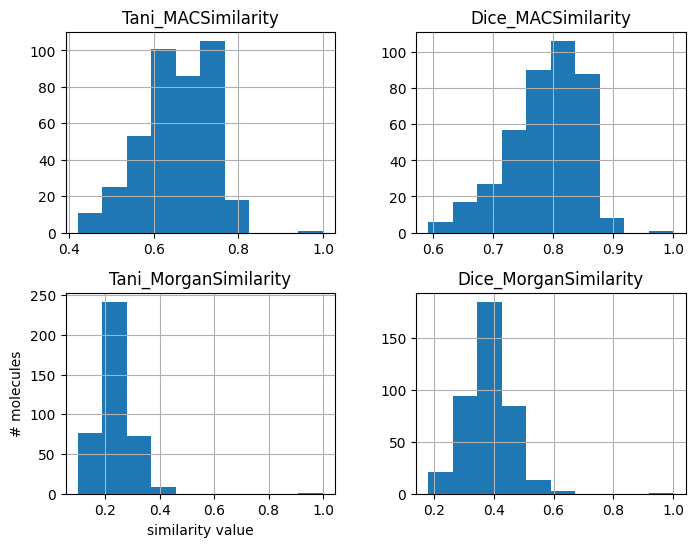

In [ ]:
# Create the figure and subplots
fig, axes = plt.subplots(figsize=(8, 6), nrows=2, ncols=2)

# Plot the histogram in the first subplot
Database.hist(['Tani_MACSimilarity'], ax=axes[0, 0])
Database.hist(['Dice_MACSimilarity'], ax=axes[0, 1])
Database.hist(['Tani_MorganSimilarity'], ax=axes[1, 0])
Database.hist(['Dice_MorganSimilarity'], ax=axes[1, 1])

# Set x-axis and y-axis labels for the second subplot
axes[1, 0].set_xlabel('similarity value')
axes[1, 0].set_ylabel("# molecules")

# Display the figure
plt.show()

Print the sorted molecules by the Tanimoto Morgan Similarity

In [ ]:
#Sort by Tanimoto Morgan coefficient
preview = Database.sort_values(["Tani_MorganSimilarity"], ascending=False).reset_index()
preview

,index,Chembl ID,Score,SMILES,MACCS,Tani_MACSimilarity,Dice_MACSimilarity,Morgan,Tani_MorganSimilarity,Dice_MorganSimilarity
0,0,CHEMBL4297590,1.000,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CCC[C@@]1(C)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,1.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,1.000000
1,2,CHEMBL3649197,0.874,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CC2CN(CC2C1)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.710526,0.830769,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.435897,0.607143
2,4,CHEMBL3586441,0.863,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1C[C@H]2CN(C[...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.710526,0.830769,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.423077,0.594595
3,1,CHEMBL3649121,0.877,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CC2CN(CC2C1)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.710526,0.830769,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.423077,0.594595
4,14,CHEMBL3670543,0.818,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CC[C@H]2CN([...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",0.730769,0.844444,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.409639,0.581197
...,...,...,...,...,...,...,...,...,...,...
395,208,CHEMBL2315050,0.628,CCC(C)NC(=O)C1=CC=CC(CC2=CC(Cl)=CC=C2OCC2=CC=...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.474359,0.643478,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.123810,0.220339
396,350,CHEMBL3740400,0.571,CCN1CCC(CC1)NC(=O)C1=C2C=CC=CN2C(=N1)C(C)C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.569620,0.725806,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.122449,0.218182
397,180,CHEMBL2315053,0.638,FC1=CC(Cl)=CC=C1COC1=CC=C(Cl)C=C1CC1=NC(=CC=C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.545455,0.705882,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.119266,0.213115
398,118,CHEMBL3740908,0.685,CC(C)C1=NC(C(=O)NC2CCN(CCF)CC2)=C2C=CC=CN12,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.544304,0.704918,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.118812,0.212389


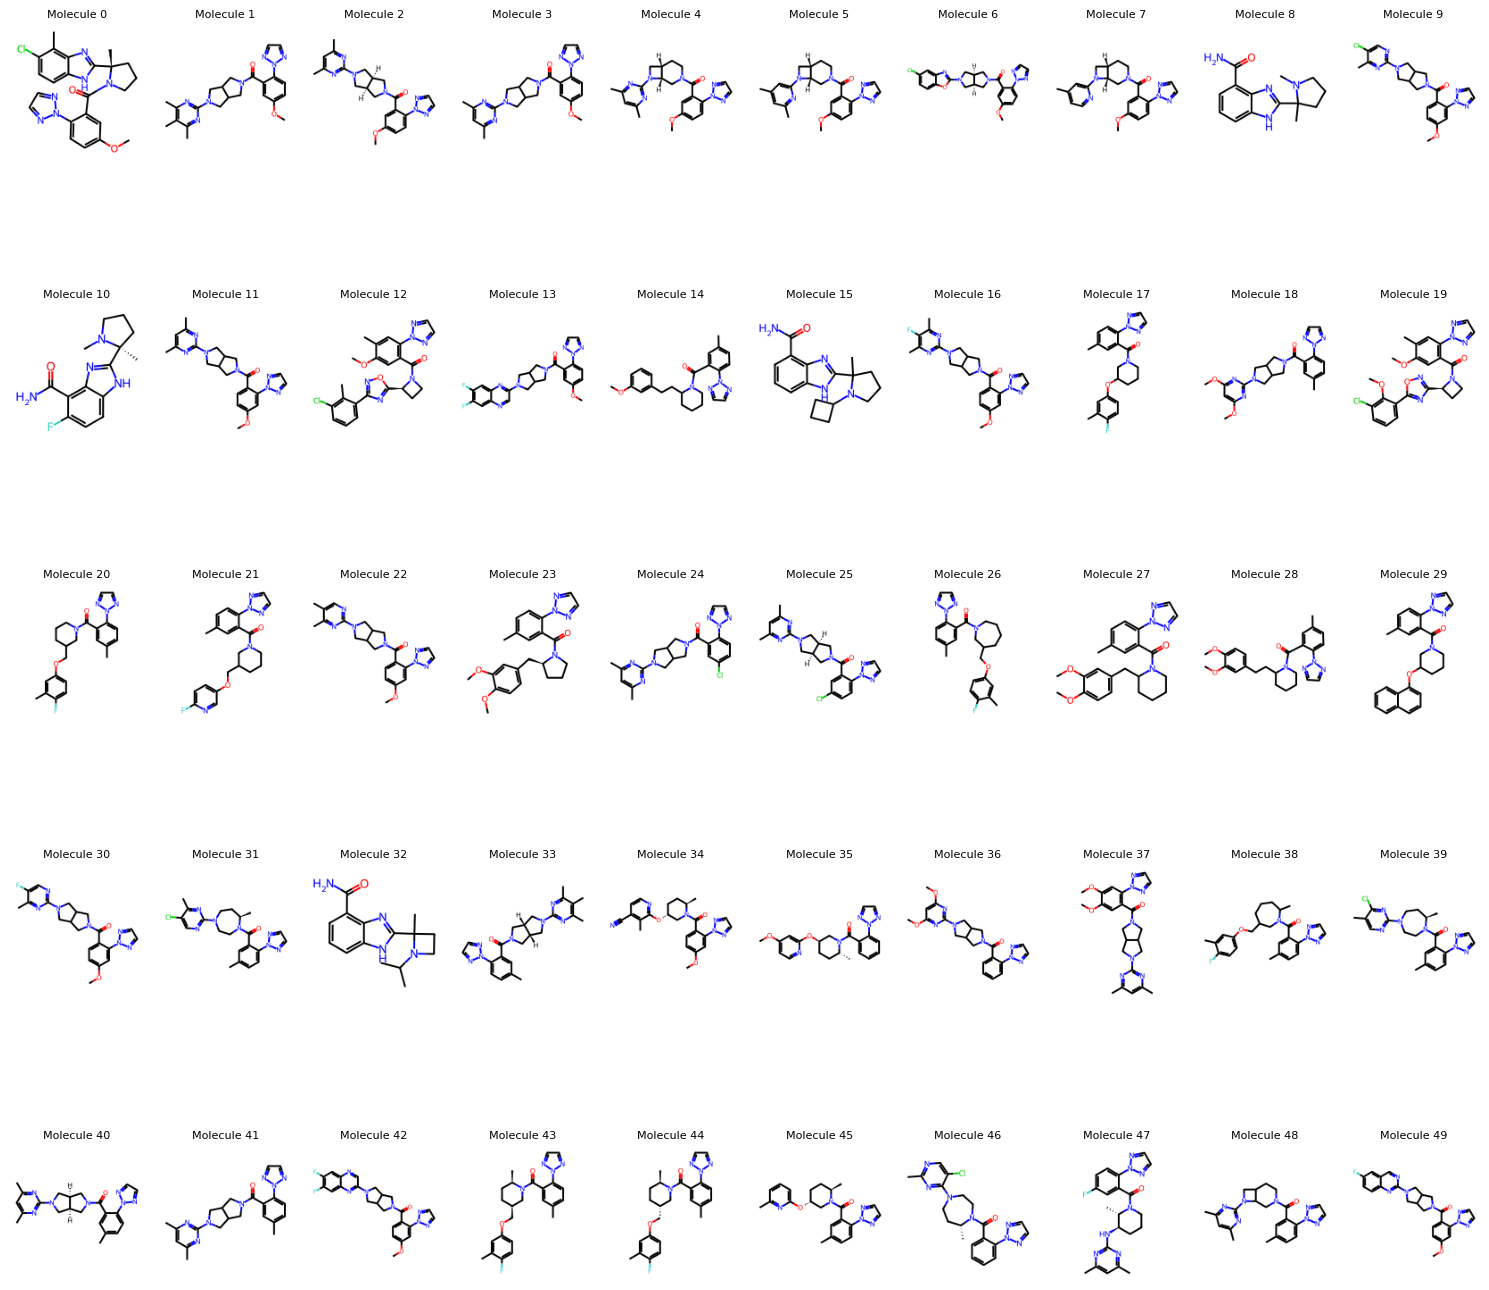

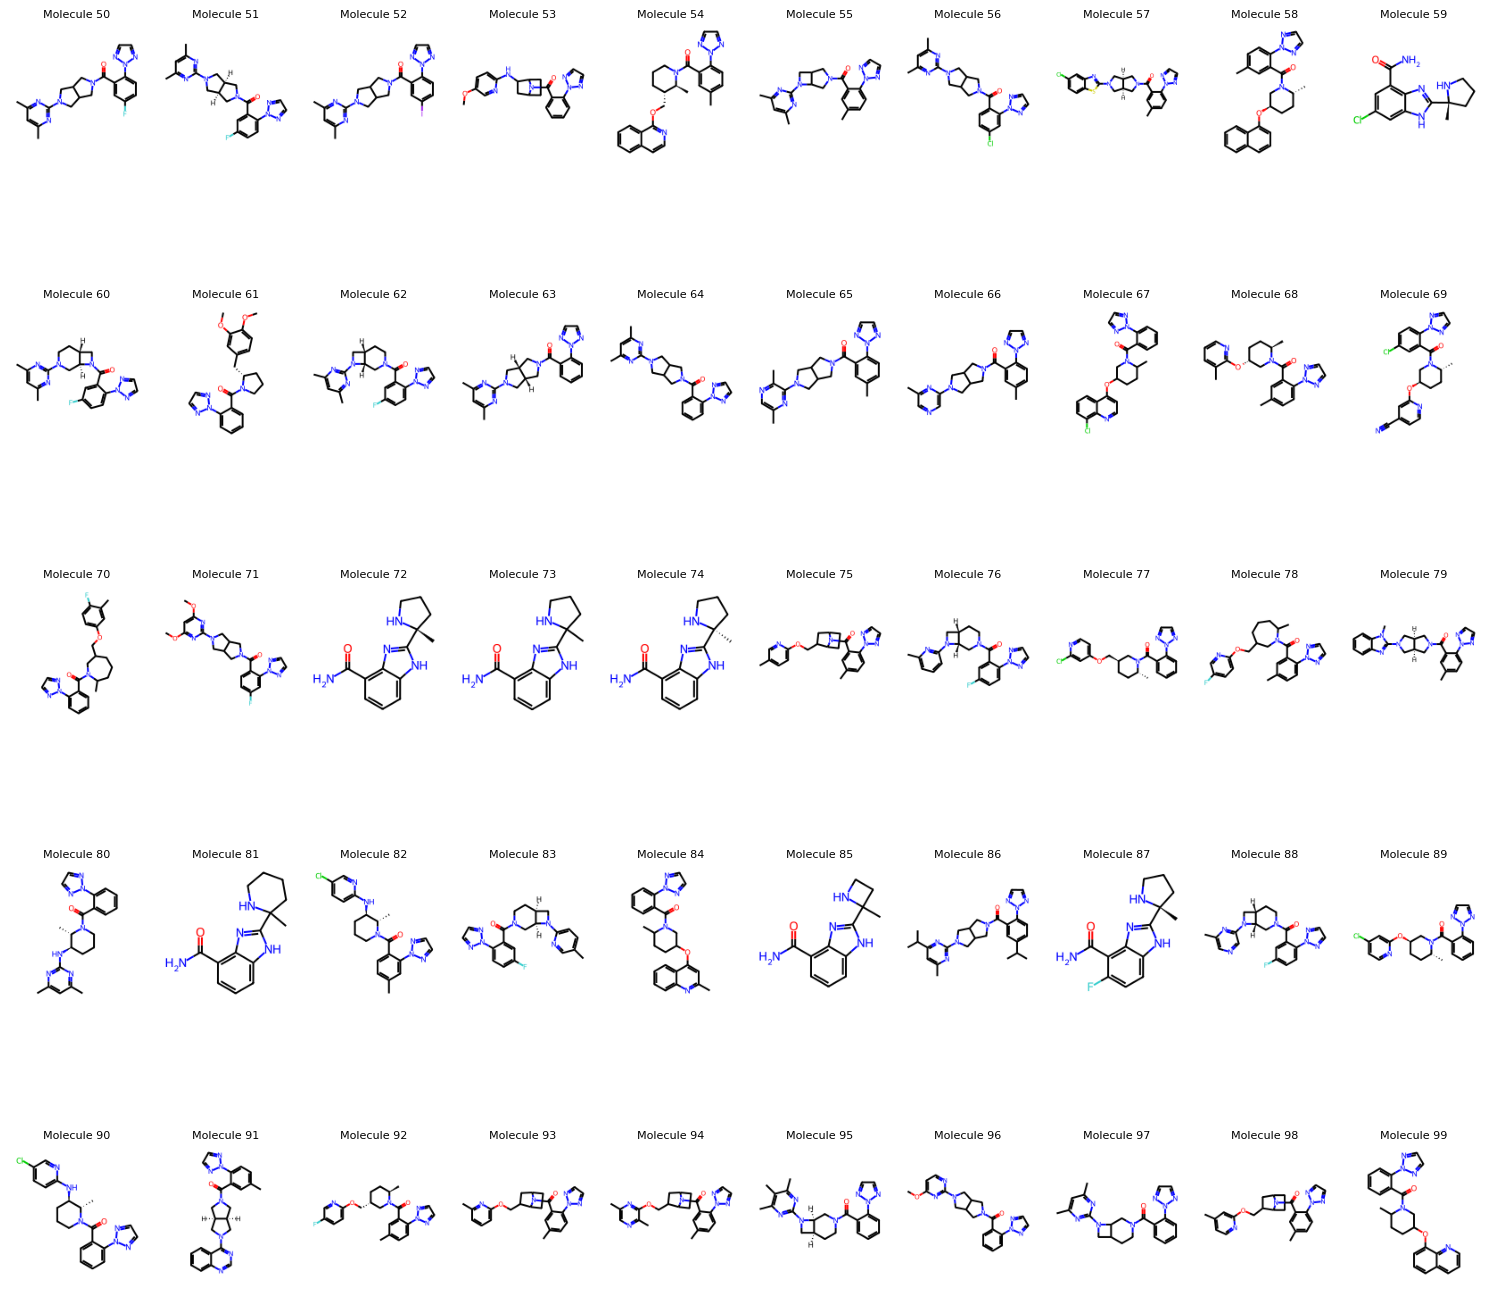

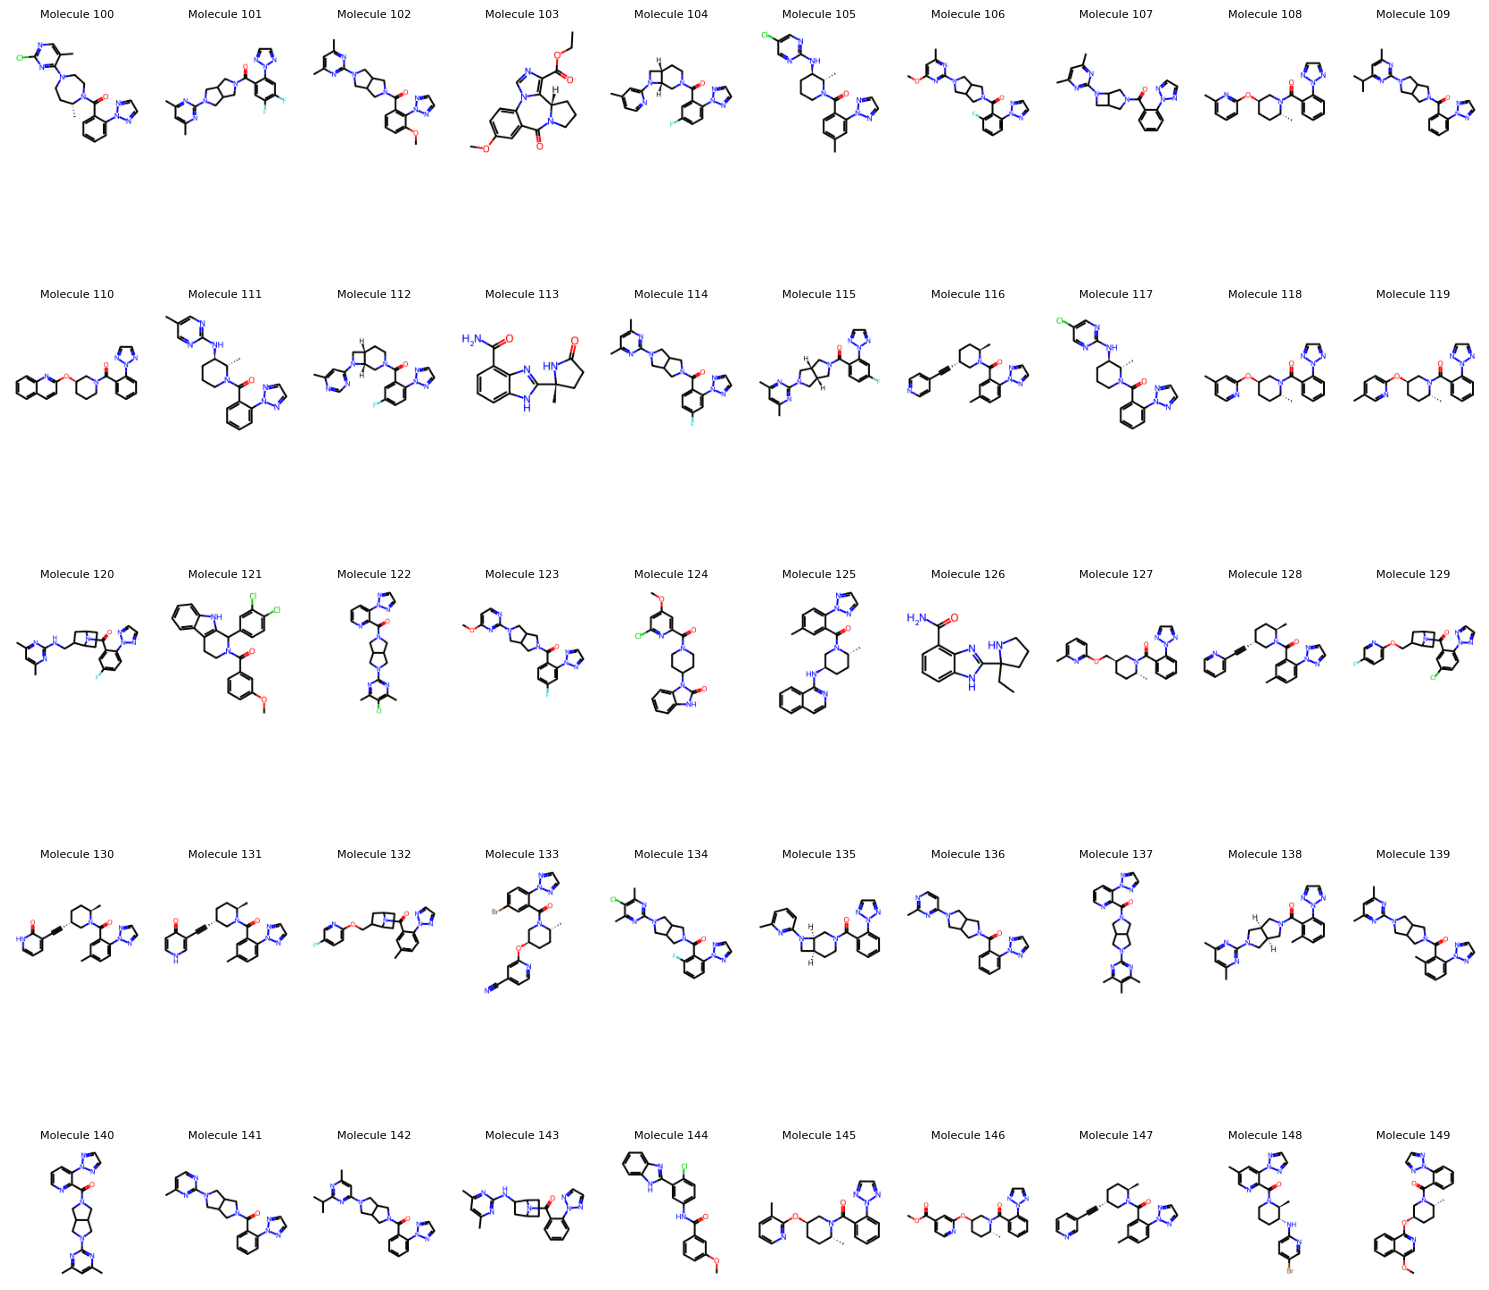

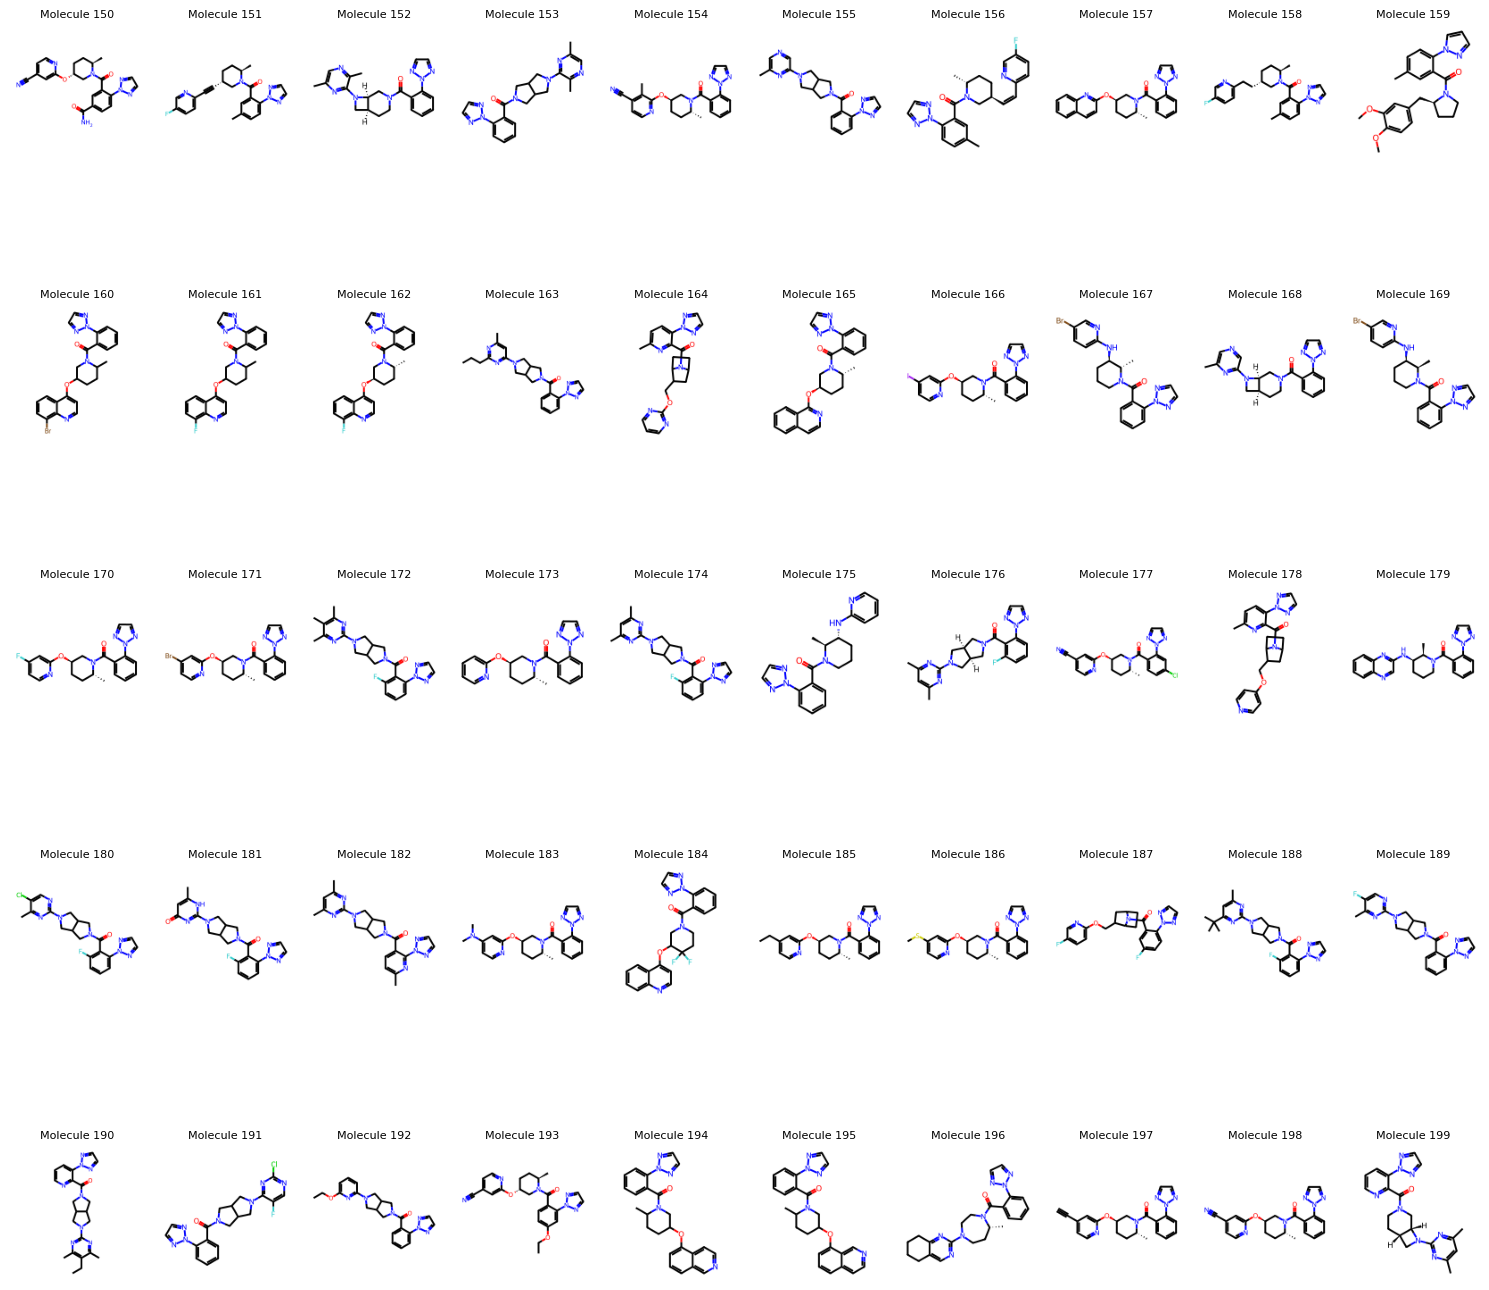

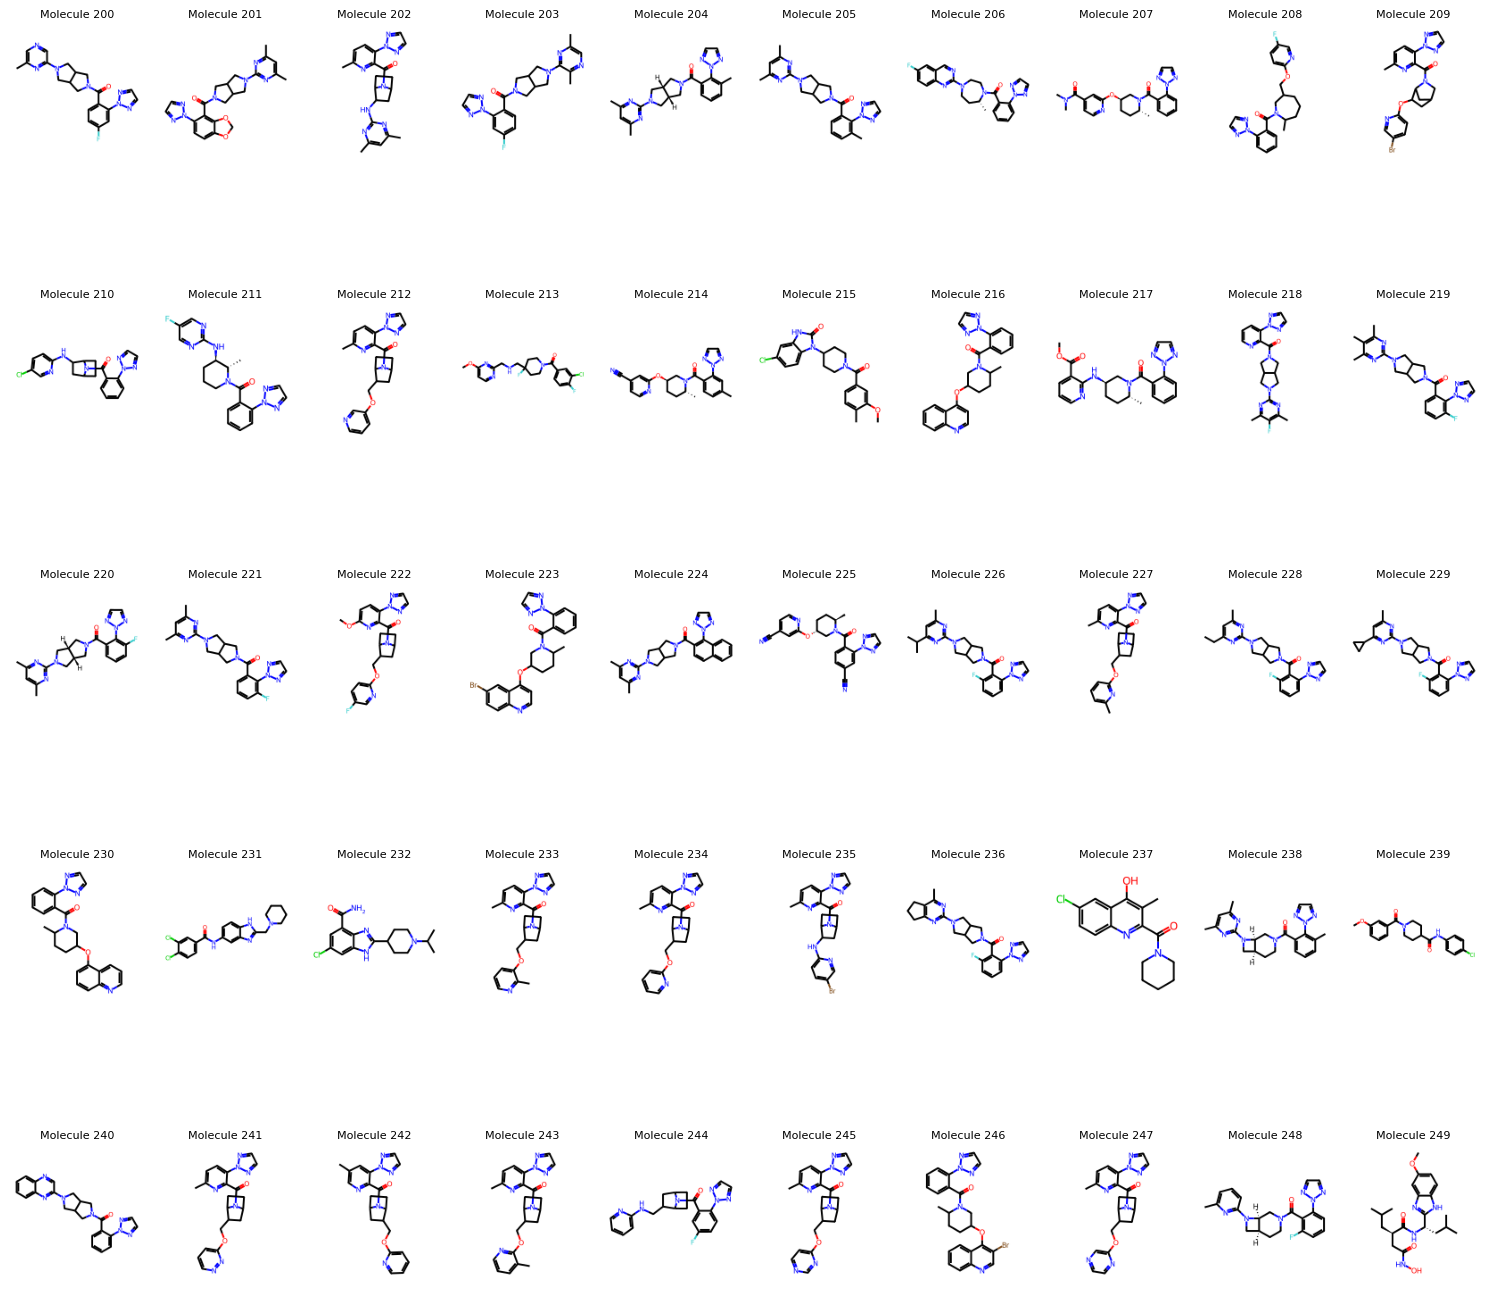

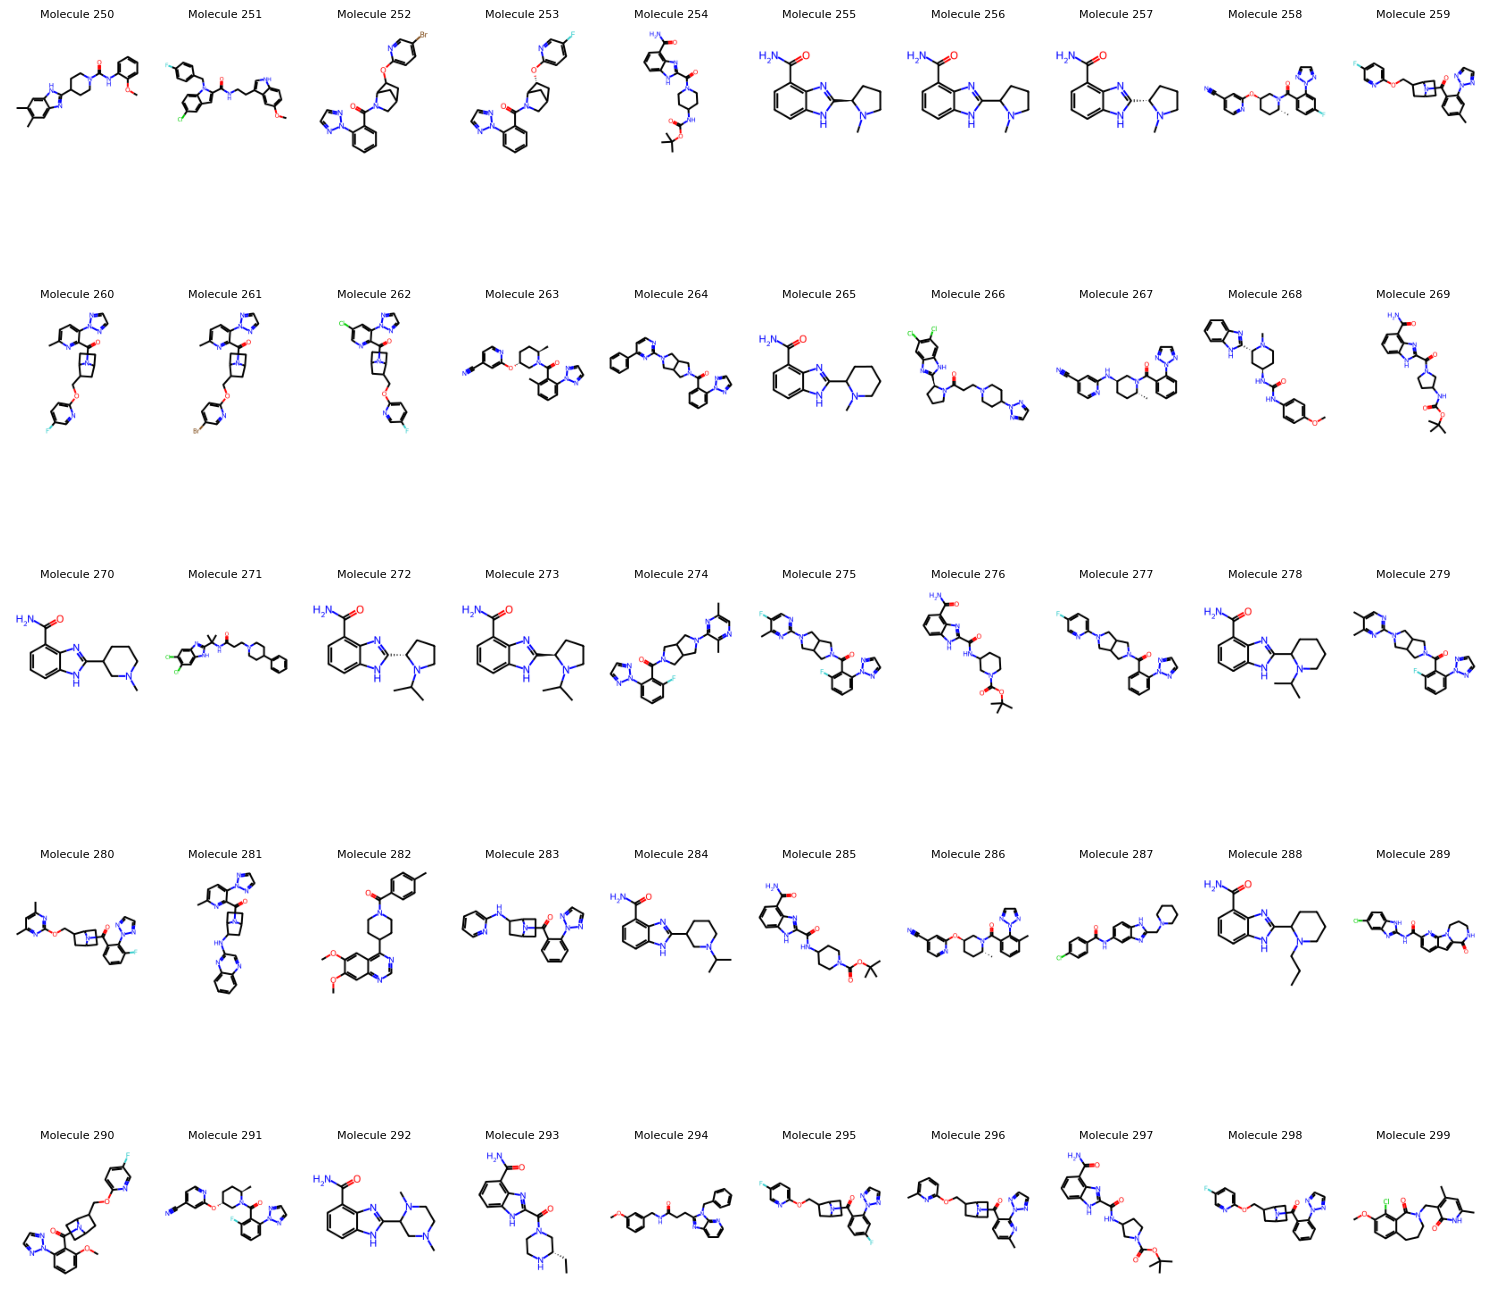

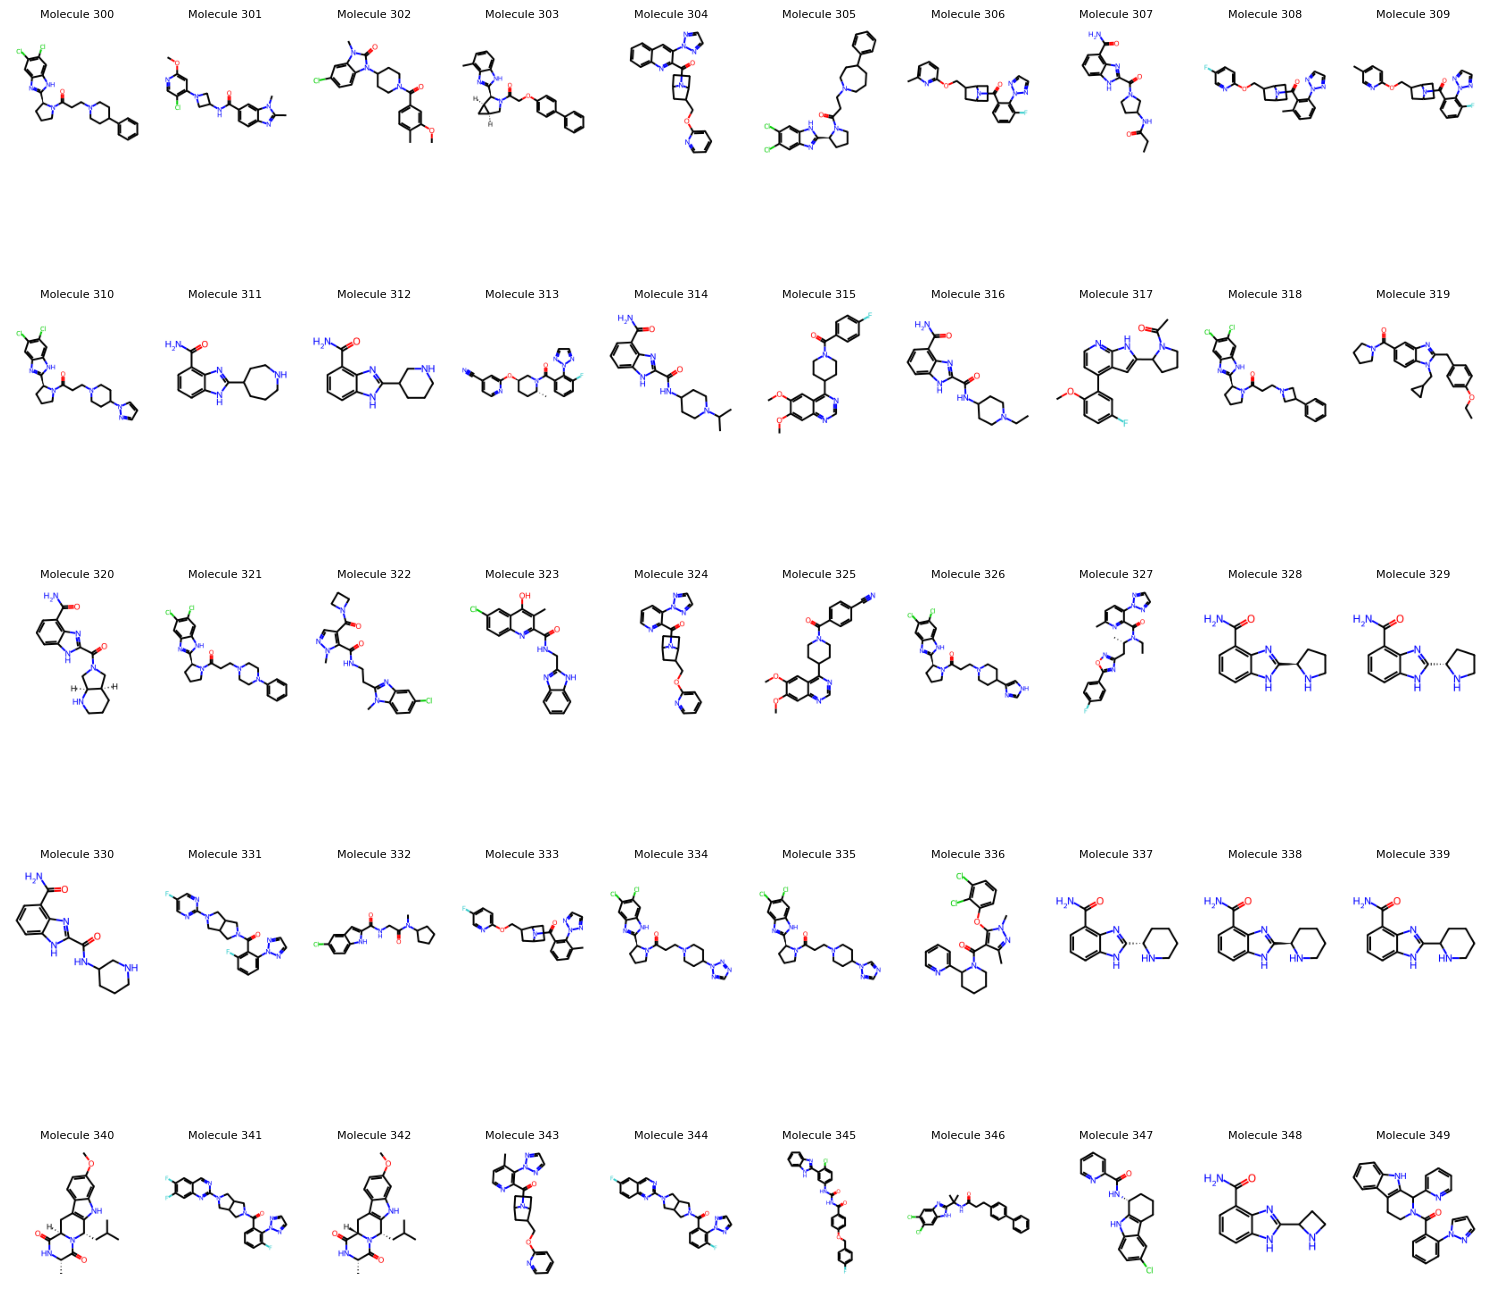

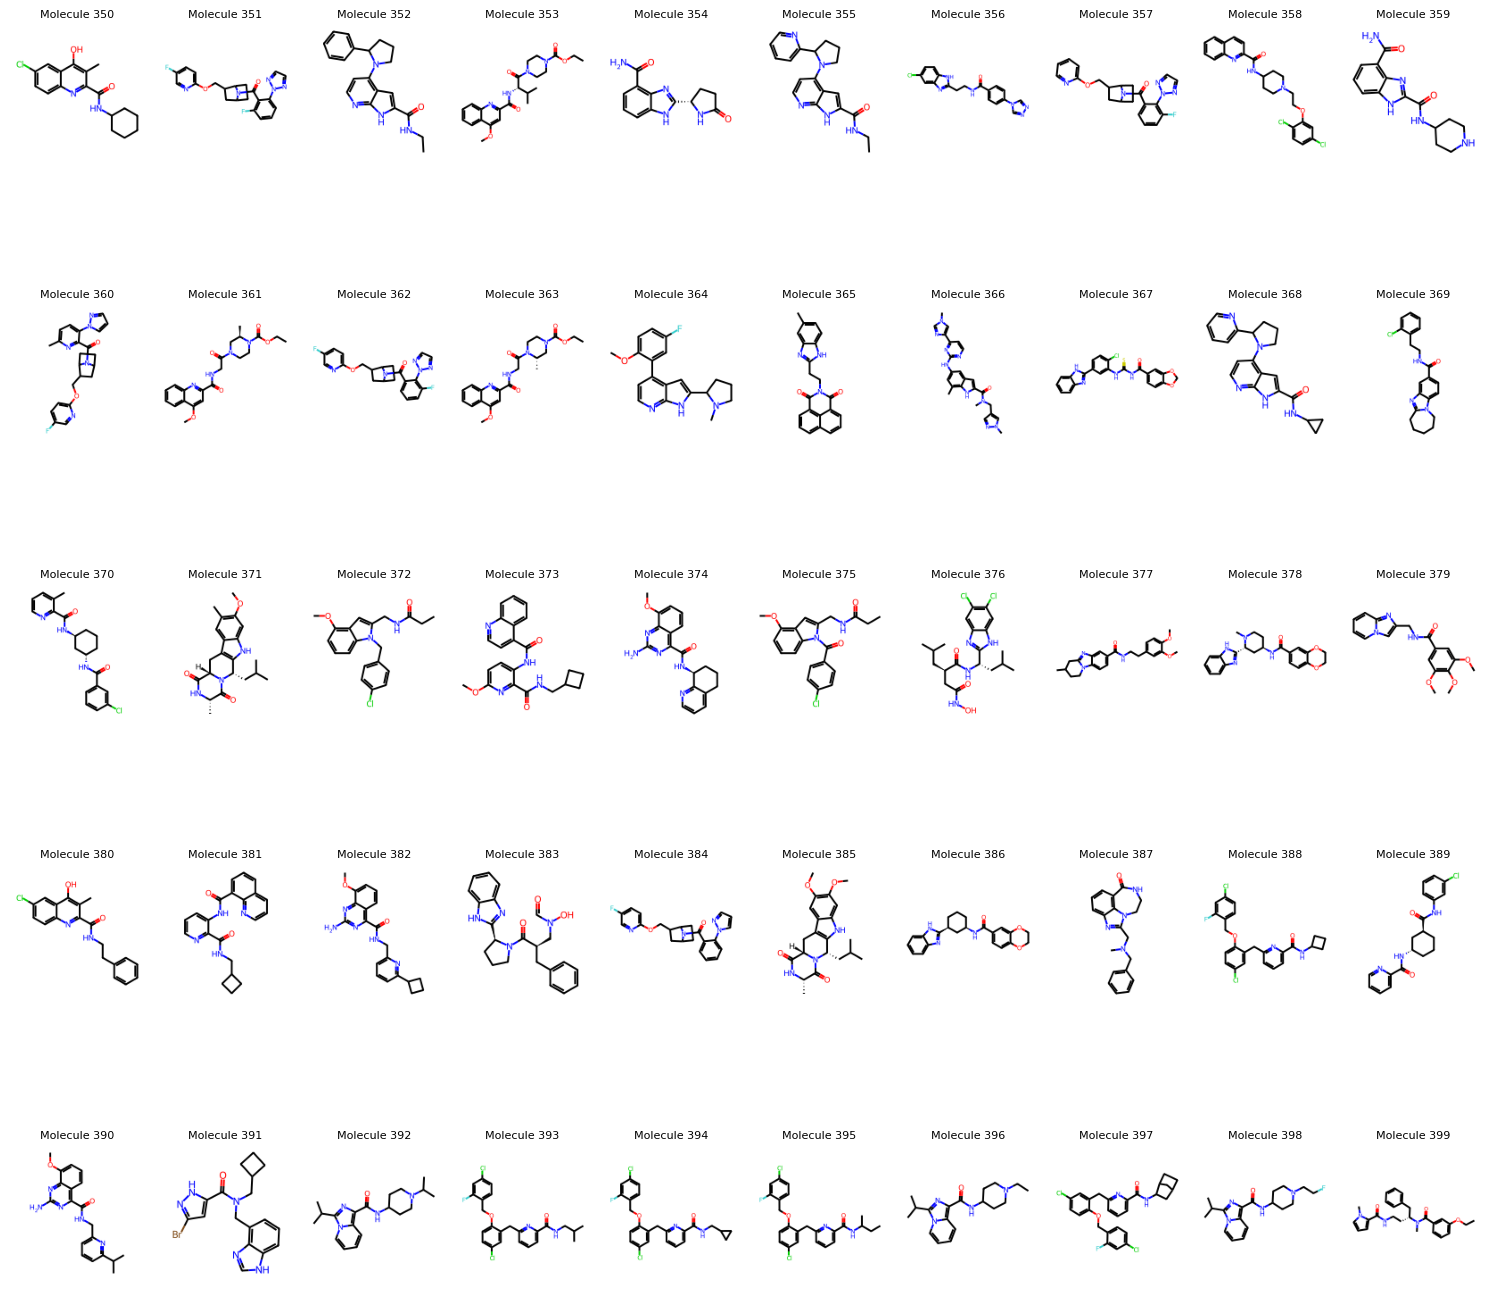

In [ ]:
from rdkit import rdBase
# Create a list to store RDKit molecules
molecule_list = []
for smiles in preview['SMILES']:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        molecule_list.append(mol)

# Set the maximum number of molecules to be drawn
Draw.rdDepictor.SetPreferCoordGen(True)

# Display all molecules in separate chunks with index numbers
chunk_size = 50
num_mols = len(molecule_list)
for i in range(0, num_mols, chunk_size):
    chunk_mols = molecule_list[i:i+chunk_size]
    fig, axes = plt.subplots(5, 10, figsize=(15, 15))  # Adjust subplots size and arrangement
    axes = axes.ravel()
    for idx, mol in enumerate(chunk_mols):
        # Draw the molecule
        img = Draw.MolToImage(mol, size=(150, 150))
        # Display the molecule image with its index number
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f"Molecule {i + idx }", fontsize=8)  # Set molecule index as title
    plt.tight_layout()
    plt.show()

We usually consider two molecules to be similar if they have at least a Tanimoto coefficient above 80. However, we are going to lower this cut off value to increase the number of molecules for further analysis.

In [ ]:
# Define cut-off.

#como esto son distancias no hay un valor de cutoff que sea fijo. Cada cutoff depende de los resultados que tengamos y de lo que queramos obtener

subset_filtered = Database.drop(Database[Database['Tani_MACSimilarity']<0.7].index) #el drop elimina todo lo que cumpla esos filtros
subset_filtered = subset_filtered.drop(subset_filtered[subset_filtered['Tani_MorganSimilarity']<0.25].index) #el drop elimina todo lo que cumpla esos filtros
print(len(subset_filtered. index))
subset_filtered

82


,Chembl ID,Score,SMILES,MACCS,Tani_MACSimilarity,Dice_MACSimilarity,Morgan,Tani_MorganSimilarity,Dice_MorganSimilarity
0,CHEMBL4297590,1.000,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CCC[C@@]1(C)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,1.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,1.000000
1,CHEMBL3649121,0.877,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CC2CN(CC2C1)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.710526,0.830769,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.423077,0.594595
2,CHEMBL3649197,0.874,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CC2CN(CC2C1)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.710526,0.830769,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.435897,0.607143
4,CHEMBL3586441,0.863,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1C[C@H]2CN(C[...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.710526,0.830769,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.423077,0.594595
8,CHEMBL3649237,0.839,COC1=CC=CC(C(=O)N2CC3CN(CC3C2)C2=NC(C)=CC(C)=...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.701299,0.824427,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.269663,0.424779
...,...,...,...,...,...,...,...,...,...
348,CHEMBL3680363,0.571,CC1CCCC(COC2=CC=C(F)C=N2)CN1C(=O)C1=CC(C)=CC=...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.753247,0.859259,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.281250,0.439024
356,CHEMBL3426138,0.567,COC(=O)C1=CC=NC(O[C@@H]2CC[C@@H](C)N(C2)C(=O)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.717949,0.835821,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.252632,0.403361
381,CHEMBL2413365,0.555,C[C@H]1[C@H](COC2=NC=CC3=CC=CC=C23)CCCN1C(=O)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.746667,0.854962,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.294737,0.455285
384,CHEMBL3704928,0.553,C[C@H]1[C@@H](CCCN1C(=O)C1=CC(F)=CC=C1N1N=CC=...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.710526,0.830769,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.300000,0.461538


## **ADMET Properties Validation**
---

In [ ]:
# Function to calculate descriptors related to ADMET properties

def calculate_ro5_properties_and_BBB(smiles):
    """
    Test if input molecule (SMILES) fulfills Lipinski's rule of five.

    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)

    logp = Descriptors.MolLogP(molecule)
    TPSA = Descriptors.TPSA (molecule)
    # Check if Ro5 conditions fulfilled
    conditions = [400< molecular_weight <= 500 , n_hba <= 10, n_hbd <= 5, logp <= 5, TPSA < 140]
    ro5_fulfilled = sum(conditions) > 4
    # Return True if no more than one out of four conditions is violated
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, TPSA, ro5_fulfilled],
        index=['molecular_weight', 'n_hba', 'n_hbd', 'logp', 'TPSA', 'ro5_fulfilled'],
    )

In [ ]:
# Calculate ADMET properties for each compound from smiles
ro5_properties = subset_filtered['SMILES'].apply(calculate_ro5_properties_and_BBB)
ro5_properties
# Concatenate ADMET properties with the 2 first columns of the previous data set
subset = subset_filtered.loc[:, ['Chembl ID', 'SMILES']]
MoleculeDatabase = pd.concat([subset, ro5_properties], axis=1)
MoleculeDatabase

,Chembl ID,SMILES,molecular_weight,n_hba,n_hbd,logp,TPSA,ro5_fulfilled
0,CHEMBL4297590,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CCC[C@@]1(C)...,450.157102,6,1,4.26542,88.93,True
1,CHEMBL3649121,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CC2CN(CC2C1)...,419.206973,8,0,1.89114,89.27,True
2,CHEMBL3649197,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1CC2CN(CC2C1)...,433.222623,8,0,2.19956,89.27,True
4,CHEMBL3586441,COC1=CC=C(N2N=CC=N2)C(=C1)C(=O)N1C[C@H]2CN(C[...,419.206973,8,0,1.89114,89.27,True
8,CHEMBL3649237,COC1=CC=CC(C(=O)N2CC3CN(CC3C2)C2=NC(C)=CC(C)=...,419.206973,8,0,1.89114,89.27,True
...,...,...,...,...,...,...,...,...
348,CHEMBL3680363,CC1CCCC(COC2=CC=C(F)C=N2)CN1C(=O)C1=CC(C)=CC=...,423.207053,6,0,3.81962,73.14,True
356,CHEMBL3426138,COC(=O)C1=CC=NC(O[C@@H]2CC[C@@H](C)N(C2)C(=O)...,421.175004,8,0,2.52100,99.44,True
381,CHEMBL2413365,C[C@H]1[C@H](COC2=NC=CC3=CC=CC=C23)CCCN1C(=O)...,441.216475,6,0,4.44362,73.14,True
384,CHEMBL3704928,C[C@H]1[C@@H](CCCN1C(=O)C1=CC(F)=CC=C1N1N=CC=...,409.202637,7,1,2.91844,88.83,True


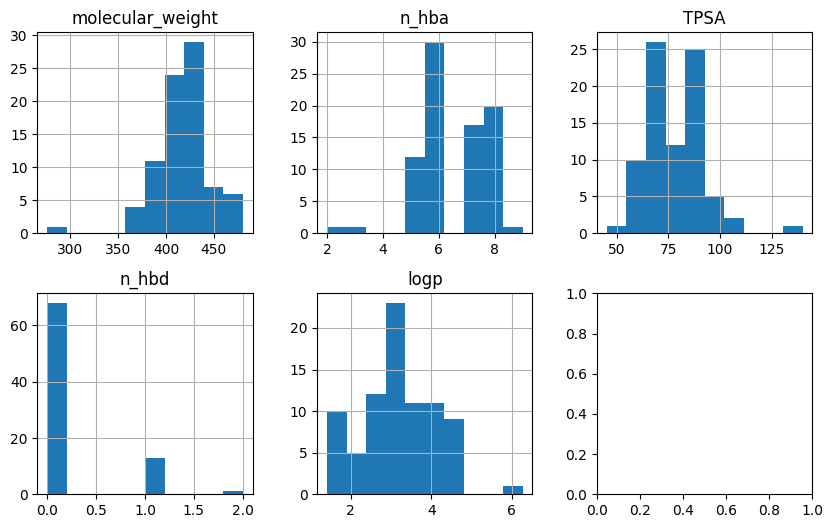

In [ ]:
fig, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=3)
MoleculeDatabase.hist(["molecular_weight"], ax=axes[0, 0])
MoleculeDatabase.hist(["n_hba"], ax=axes[0, 1])
MoleculeDatabase.hist(["n_hbd"], ax=axes[1, 0])
MoleculeDatabase.hist(["logp"], ax=axes[1, 1])
MoleculeDatabase.hist(["TPSA"], ax=axes[0, 2])
fig;

Now we are going to select the molecules that have the 5 rules fullfilled.

In [ ]:
#And separate by valid and invalid drugs
MoleculeDatabase_ro5_fulfilled = MoleculeDatabase[MoleculeDatabase["ro5_fulfilled"]]
MoleculeDatabase_ro5_violated = MoleculeDatabase[~MoleculeDatabase["ro5_fulfilled"]]
print(f"{len(MoleculeDatabase_ro5_fulfilled)} Ro5-following compounds found")

64 Ro5-following compounds found


There are 64 molecules that have the 5 conditions. As we can see in the graphs, a some of the compounds didn't have a molecular_weight between 400 and 50. Also some molecule had a logP value bigger than 5.

Lets plot the values to confirm that the selection was good.

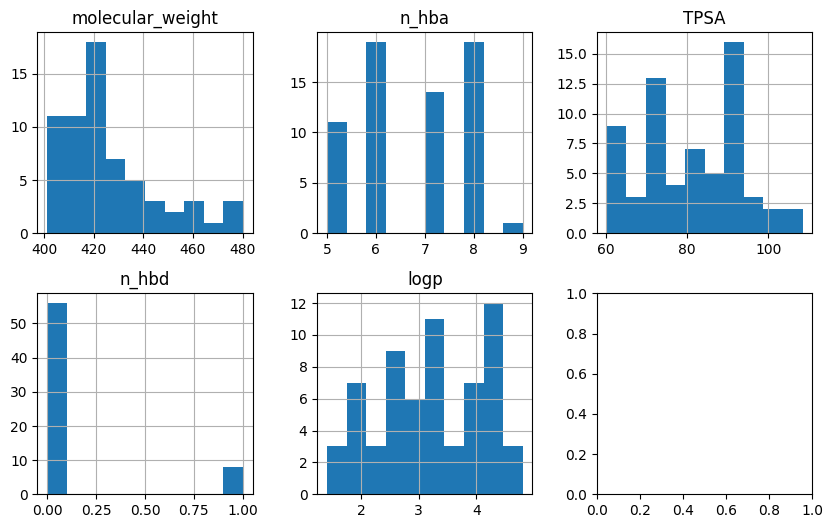

In [ ]:
fig, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=3)
MoleculeDatabase_ro5_fulfilled.hist(["molecular_weight"], ax=axes[0, 0])
MoleculeDatabase_ro5_fulfilled.hist(["n_hba"], ax=axes[0, 1])
MoleculeDatabase_ro5_fulfilled.hist(["n_hbd"], ax=axes[1, 0])
MoleculeDatabase_ro5_fulfilled.hist(["logp"], ax=axes[1, 1])
MoleculeDatabase_ro5_fulfilled.hist(["TPSA"], ax=axes[0, 2])
fig;

## **Pharmacophore Based Virtual Screning**
---

### 1 - Create the Search database
Since PharmIt requires the db format to be “.smi”, we make the necessary changes:

In [ ]:
pharmit_input = MoleculeDatabase_ro5_fulfilled['SMILES'] + ' ' + MoleculeDatabase_ro5_fulfilled['Chembl ID']
pharmit_input.to_csv('./pharmit_input.smi', index=False, header=False)

### 2 - Create the Validation database

Known compounds that bind to the target

In [ ]:
# Filtering data set by type "IC50" and sorting it by ascending values
IC50_activity_table = full_activity_table[full_activity_table['type'] == 'IC50'].copy()

IC50_activity_table['standard_value'] = IC50_activity_table['standard_value'].astype('float')
IC50_activity_table = IC50_activity_table.sort_values(['standard_value'], ascending=[True])

display(IC50_activity_table)

In [ ]:
# take the first 10 molecules
validation_database = IC50_activity_table.head(10)

pharmit_input = validation_database['canonical_smiles'] + ' ' + validation_database['molecule_chembl_id']
pharmit_input.to_csv('./pharmit_input_validation.smi', index=False, header=False)

### 3 - Identify and prepare the ligands  
One of the main steps is the selection of the ligands to be used. I want to create the pharmacophore with the 3 approved drugs:
- CHEMBL1083659 cristalographic structure is available.
- CHEMBL3545367 and CHEMBL4297590 there are not available structure. In this case we will obtain the structure from the Smiles (because only one molecule is available in PDB, so it will be necessary to calculate all possible conformers for each molecules and minimize their energy. In order to identify the most stable 3D structure for each of them.


      1. CHEMBL3545367: Cc1ncc(OC[C@@]2(c3cccc(F)c3)C[C@H]2C(=O)Nc2ccc(F)cn2)c(C)n1
      2. CHEMBL4297590: COc1ccc(-n2nccn2)c(C(=O)N2CCC[C@@]2(C)c2nc3c(C)c(Cl)ccc3[nH]2)c1
      3. CHEMBL1083659: Cc1ccc(-n2nccn2)c(C(=O)N2CCN(c3nc4cc(Cl)ccc4o3)CC[C@H]2C)c1 - Available in PDB


Let's do a first visualization of the molecules.

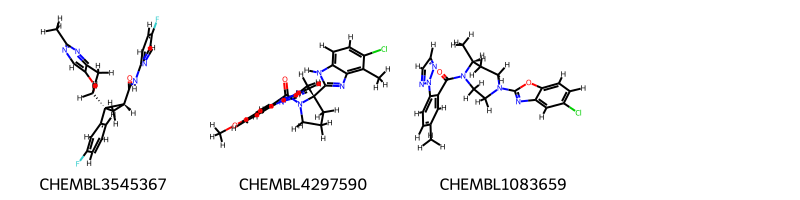

In [9]:
#smiles for the 3 molecules
smiles = ['Cc1ncc(OC[C@@]2(c3cccc(F)c3)C[C@H]2C(=O)Nc2ccc(F)cn2)c(C)n1', 'COc1ccc(-n2nccn2)c(C(=O)N2CCC[C@@]2(C)c2nc3c(C)c(Cl)ccc3[nH]2)c1', 'Cc1ccc(-n2nccn2)c(C(=O)N2CCN(c3nc4cc(Cl)ccc4o3)CC[C@H]2C)c1']

mol_objects = []
for smi in smiles:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        mol = Chem.AddHs(mol)  # Add hydrogens
        AllChem.EmbedMultipleConfs(mol, numConfs=20)  # Generate conformers - I chose 20 conformers
        energies = AllChem.MMFFOptimizeMoleculeConfs(mol)  # Minimize energy for each conformer
        # Get conformer with the lowest energy
        min_energy = min(energies)
        min_idx = energies.index(min_energy)
        min_conf = mol.GetConformer(min_idx)
        # You can access the coordinates of the most stable conformer here if needed
        # Create a new mol object with the lowest energy conformer
        lowest_energy_mol = Chem.Mol(mol, False, min_conf.GetId())  # Create a new molecule with the lowest energy conformer
        mol_objects.append(lowest_energy_mol)

#visualize the molecules we are going to make the pharmacophore with
Draw.MolsToGridImage(
    mol_objects,
    molsPerRow=4,
    legends=[f" {ID}" for ID in ["CHEMBL3545367", "CHEMBL4297590", "CHEMBL1083659"]]
)

There is a clear similarity between them so we are gonna find common chemical characteristics.

**Chimera preparation of the molecules**




We are gonna make docking in order to obtain the structure that fit into the target pocket. This is done in chimera after an energy minimization procedure, and redocking was performed with 6TPJ.pdb protein that have suvorexant (CHEMBL1083659)  structure linked to the protein. By doing this we obtained the 3 ligands fitted to the target.

The results are in 3 different sdf files: LEM.sdf DAR.sdf and SUV.sdf

Total number of loaded molecules: 3


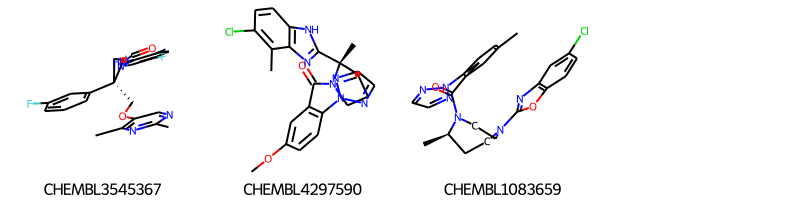

In [3]:
# List of SDF file names
sdf_files = ['C:/Users/joaco/Desktop/Master/Lead Discovery/Entraga final/pharmacophore/LEM.sdf',
             'C:/Users/joaco/Desktop/Master/Lead Discovery/Entraga final/pharmacophore/DAR.sdf',
             'C:/Users/joaco/Desktop/Master/Lead Discovery/Entraga final/pharmacophore/SUV.sdf'
             ]

# List to store loaded molecules
molecules = []

# Try to load each SDF file
for sdf_file in sdf_files:
    suppl = Chem.SDMolSupplier(sdf_file)
    if suppl is not None:
        # Add each molecule to the list
        molecules.extend([mol for mol in suppl if mol is not None])
    else:
        print(f"Error opening SDF file: {sdf_file}")

# Print information about the loaded molecules
print("Total number of loaded molecules:", len(molecules))
#print molecules with the conformer that fit into the pocket
Draw.MolsToGridImage(
    molecules,
    molsPerRow=4,
    legends=[f" {ID}" for ID in ["CHEMBL3545367", "CHEMBL4297590", "CHEMBL1083659"]]
)

We add Hydrogens without minimizing the structure again because this change the desired conformer. Then we align the molecules.

In [4]:
molecules_with_hydrogens=[]
# Add hydrogens and generate conformers for each loaded molecule
for mol in molecules:
    if mol is not None:
        mol_with_hydrogens = Chem.AddHs(mol,addCoords=True)
        # Add the molecule to the list
        molecules_with_hydrogens.append(mol_with_hydrogens)

In [5]:
#ALIGN THE MOLECULES
# Assuming you already have the list of molecules with hydrogens

# Align the molecules
ref_mol = molecules_with_hydrogens[0]
aligned_mols = [ref_mol]  # The first molecule is the reference, so it's already aligned

for mol in molecules_with_hydrogens[1:]:
    pyO3A = rdMolAlign.GetO3A(mol, ref_mol)  # Perform alignment
    pyO3A.Align()

    # Use the aligned conformations for visualization
    aligned_mol = Chem.Mol(mol)
    aligned_mols.append(aligned_mol)

# Visualize the alignment
viewer = py3Dmol.view(width=600, height=400)

# Add the reference molecule
viewer.addModel(Chem.MolToMolBlock(ref_mol), 'sdf', {'keepH': True, 'conformer': 0})

# Add the aligned molecules
for i, aligned_mol in enumerate(aligned_mols[1:], start=1):
    viewer.addModel(Chem.MolToMolBlock(aligned_mol), 'sdf', {'keepH': True, 'conformer': 0, 'series': i})

# Style the visualization
viewer.setStyle({'stick': {}})

# Zoom to fit all molecules
viewer.zoomTo()

# Show the visualization
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [6]:
# Save the aligned molecules to an SDF file
output_sdf_file = 'align_ligands.sdf'
with Chem.SDWriter(output_sdf_file) as writer:
    for aligned_mol in aligned_mols:
        writer.write(aligned_mol)

### 4 - Identify pharmacophoric features

Chemical features in the RDKit are defined using a SMARTS-based feature definition language (described in detail in the RDKit book). To identify chemical features in molecules, we must build a feature factory and then use the factory to search for features.

The feature factory is in "BaseFeatures.fdef" file, where the most common features are defined.

In [7]:
#this file is necessary for RDKit to calculate the features
feature_factory = AllChem.BuildFeatureFactory(str(os.path.join('C:/Users/joaco/Desktop/Master/Lead Discovery/Entraga final/pharmacophore/BaseFeatures.fdef'))) #Included here the path pf BaseFeatures.fdef

In [8]:
#Load ligands
mols = [m for m in Chem.SDMolSupplier('align_ligands.sdf')]

First we take a look to the obtained characteristics.

In [9]:
molecule_feature_frequencies = []
for molecule in mols:
    features = [feature.GetFamily() for feature in feature_factory.GetFeaturesForMol(molecule)]
    feature_frequency = collections.Counter(features)
    molecule_feature_frequencies.append(feature_frequency)

feature_frequencies_df = (
    pd.DataFrame(
        molecule_feature_frequencies,
        index=[f"Mol{i}" for i, _ in enumerate(mols, 1)],
    )
    .fillna(0)
    .astype(int)
)
feature_frequencies_df.transpose()

,Mol1,Mol2,Mol3
Donor,1,3,1
Acceptor,7,5,4
Aromatic,3,4,4
Hydrophobe,3,3,3
LumpedHydrophobe,2,2,2
PosIonizable,0,1,0



We want to cluster features per feature type. To do this we collect all coordinates of features and store them per feature type.

We concentrate only on the following feature types: hydrogen bond acceptors (acceptors), hydrogen bond donors (donors), Aromatic and hydrophobic contacts (hydrophobics). This are the most common features and the ones that usually interact the most with the target.

In [10]:
acceptors = []
donors = []
aromatics = []
hydrophobics = []

for molecule in mols:
    acceptors.append(feature_factory.GetFeaturesForMol(molecule, includeOnly="Acceptor"))
    donors.append(feature_factory.GetFeaturesForMol(molecule, includeOnly="Donor"))
    aromatics.append(feature_factory.GetFeaturesForMol(molecule, includeOnly="Aromatic"))
    hydrophobics.append(feature_factory.GetFeaturesForMol(molecule, includeOnly="Hydrophobe"))

features = {
    "donors": donors,
    "acceptors": acceptors,
    "aromatics": aromatics,
    "hydrophobics": hydrophobics,
}

In [11]:
# get the coordinates for each characteristic
features_coord = {
    "donors": [list(item.GetPos()) for sublist in features["donors"] for item in sublist],
    "acceptors": [list(item.GetPos()) for sublist in features["acceptors"] for item in sublist],
    "aromatics": [list(item.GetPos()) for sublist in features["aromatics"] for item in sublist],
    "hydrophobics": [
        list(item.GetPos()) for sublist in features["hydrophobics"] for item in sublist
    ],
}

 **Generate ensemble pharmacophores**

K-means clustering is a method for partitioning a dataset into groups (clusters) based on similarity. In this context, it's used to group similar features of the same type together.

* `kq`: This parameter determines the number of clusters (k) per feature type based on the number of feature points.

To determine the optimal number of clusters (kk) for clustering 4 compounds with 4 features each, you can consider several methods. The Elbow Method involves running k-means for various kk values and identifying the "elbow" point on a plot of inertia versus kk. The Silhouette Method calculates the silhouette coefficient for different kk values, choosing the kk that maximizes this coefficient.

Set static parameters for cluster selection:

* `min_cluster_size`: We only want to retain clusters that potentially contain features from most molecules in our ligand ensemble. Therefore, we set this variable to 90% of the number of molecules in our ligand ensemble.
* `top_cluster_number`: With this parameter, we select only the largest clusters.

In [12]:
kq = 5
min_cluster_size = int(len(mols) * 0.9)
top_cluster_number = 7


**Define k-means clustering and cluster selection functions**

We define a function that calculates the centers of clusters, which are derived from k-means clustering.

In [13]:
def clustering(feature_coord, kq):
 # Define parameter k as feature number divided by "k quotient"
    k = math.ceil(len(feature_coord) / kq)
    print(f"Clustering: \nVariable k in k-means: {k} of {len(feature_coord)} points\n")
    # Initialize k-means and compute clustering
    k_means = cluster.KMeans(n_clusters=k)
    k_means.fit(feature_coord)

    return k_means

In [14]:
from sklearn import cluster # scikit-learn: Machine learning library for clustering

k_means = {
    "donors": clustering(features_coord["donors"], kq),
    "acceptors": clustering(features_coord["acceptors"], kq),
    "aromatics": clustering(features_coord["aromatics"], kq),
    "hydrophobics": clustering(features_coord["hydrophobics"], kq),
}

Clustering: 
Variable k in k-means: 1 of 5 points



C:\Users\joaco\anaconda3\envs\joaquin\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\joaco\anaconda3\envs\joaquin\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\joaco\anaconda3\envs\joaquin\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\joaco\anaconda3\envs\joaquin\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to ha

Clustering: 
Variable k in k-means: 4 of 16 points

Clustering: 
Variable k in k-means: 3 of 11 points

Clustering: 
Variable k in k-means: 2 of 9 points



C:\Users\joaco\anaconda3\envs\joaquin\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\joaco\anaconda3\envs\joaquin\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


**Select relevant clusters**

For each feature type, we select relevant clusters with our defined `get_clusters` function.

In [15]:
def get_clusters(k_means_dict, data_type, min_cluster_size, top_cluster_number):

    # Extract the k-means clustering object for the specified data type
    k_means = k_means_dict.get(data_type)

    if k_means is None:
        raise ValueError(f"No clustering found for data type '{data_type}' in the provided dictionary.")

    # Count clusters by size
    feature_labels = k_means.labels_
    feature_labels_count = Counter(feature_labels)

    # Display clusters sorted by size
    feature_labels_count = sorted(
        feature_labels_count.items(), key=operator.itemgetter(1), reverse=True
    )
    print(f"Clusters sorted by size for {data_type}: \n{feature_labels_count}\n")

    return feature_labels_count

In [16]:
selected_clusters_donors = get_clusters(k_means, "donors", min_cluster_size, top_cluster_number)
selected_clusters_acceptors = get_clusters(k_means, "acceptors", min_cluster_size, top_cluster_number)
selected_clusters_aromatics = get_clusters(k_means, "aromatics", min_cluster_size, top_cluster_number)
selected_clusters_hydrophobics = get_clusters(k_means, "hydrophobics", min_cluster_size, top_cluster_number)

Clusters sorted by size for donors: 
[(0, 5)]

Clusters sorted by size for acceptors: 
[(3, 5), (2, 4), (1, 4), (0, 3)]

Clusters sorted by size for aromatics: 
[(2, 4), (0, 4), (1, 3)]

Clusters sorted by size for hydrophobics: 
[(0, 5), (1, 4)]



We will select the most relevant clusters based on the evaluation.

In our case, we will choose the first 1 for donors, the 2 initial ones for acceptors (both have high score), the 2 initial ones for aromatics (both have high score and aromatics are important in this specific ligand-target interaction) and the first 1 for hydrophobics.

In [17]:
cluster_indices_sel = {
    "donors": [0],
    "acceptors": [0,1],
    "aromatics": [1],
    "hydrophobics": [0],
}

In [18]:
# Function to obtain the coordinates of the selected cluster center
def get_selected_cluster_center_coords(k_means, cluster_indices_sel):
    cluster_centers = k_means.cluster_centers_

    # Convert to list and then to a pandas Series (for element selection by indices)
    cluster_centers = pd.Series(cluster_centers.tolist())
    # Select cluster centers by indices of selected clusters
    cluster_centers_sel = cluster_centers[cluster_indices_sel]

    return list(cluster_centers_sel)

In [19]:
selected_cluster_centers = {
    feature_type: get_selected_cluster_center_coords(k_means[feature_type], cluster_indices)
    for feature_type, cluster_indices in cluster_indices_sel.items()
}

In [20]:
selected_cluster_centers

{'donors': [[14.29402, 17.11734, 26.273]],
 'acceptors': [[11.368733333333333, 15.800666666666666, 25.644166666666667],
  [18.0313, 17.006149999999998, 24.51995]],
 'aromatics': [[16.574071111111113, 18.761495555555555, 20.85473777777778]],
 'hydrophobics': [[12.59156, 16.86676, 27.46892]]}

### 5 - Show clusters: pharmacophoric characteristics

In this last step, we combine the clustered pharmacophoric features (all features), to one ensemble pharmacophore, representing the pharmacophoric properties of the four selected ligands.


In [21]:
feature_colors = {
    "donors": (0, 0.9, 0),  # Green
    "acceptors": (0.9, 0, 0),  # Red
    "aromatics": (0, 0.9, 0.9),  # Blue
    "hydrophobics": (1, 0.9, 0),  # Yellow
}
def show_ligands(molecules):
    """Generate a view of the ligand molecules.

    Parameters: molecules: list of rdkit.Chem.rdchem.Mol

    Returns: nglview.widget.NGLWidget
    """
    view = nv.NGLWidget()
    for molecule in molecules:
        component = view.add_component(molecule)
        time.sleep(0.1)
        component.clear()
        component.add_ball_and_stick(multipleBond=True)
    return view

def visualize_features(
    molecules,
    features,
    feature_type="features",
    color="yellow",
    sphere_radius=0.5,
):

    view = show_ligands(molecules)
    for i, feature_set in enumerate(features, 1):
        for feature in feature_set:
            loc = list(feature.GetPos())
            label = f"{feature_type}_{i}"
            view.shape.add_sphere(loc, color, sphere_radius, label)
    return view
def visualize_clusters(
    molecules,
    features,
    clusters,
    feature_type="features",
    color="yellow",
    cluster_radius=1.5,
    feature_radius=0.5
):

    view = visualize_features(
        molecules,
        features,
        feature_type,
        color=color,
        sphere_radius=feature_radius,
    )
    for i, center in enumerate(clusters, 1):
        view.shape.add_sphere(list(center), color, cluster_radius, f"cluster_{feature_type}_{i}")
    return view


In [22]:
view = show_ligands(mols)
# Load clusters
for feature_type in cluster_indices_sel.keys():
    centers = selected_cluster_centers[feature_type]
    for i, loc in enumerate(centers):
        sphere_radius = 1
        feature_color = feature_colors[feature_type]
        label = f"{feature_type}_c{i}"
        view.shape.add_sphere(loc, feature_color, sphere_radius, label)

view

NGLWidget()

For the Screening with our database, we need to take this common features (type and coordinates) and load it in Pharmit - https://pharmit.csb.pitt.edu/


In [52]:
selected_cluster_centers

{'donors': [[14.29402, 17.11734, 26.273]],
 'acceptors': [[16.373525, 15.286625, 25.746275],
  [15.9644, 16.61208, 21.15068]],
 'aromatics': [[16.685115, 15.482965833333333, 23.310045833333334]],
 'hydrophobics': [[16.35575, 16.042925, 21.9963]]}

### 6 - Virtual Screening in Pharmit

With the validation database, the search database and the pharmacophore features the search in Pharmit was performed.